In [1]:
import os
import os.path
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

SCRIPT_PATH = os.path.join('..', 'scripts')
if SCRIPT_PATH not in sys.path:
    sys.path.append(SCRIPT_PATH)
from features import CATEGORICAL_FEATURES, VECTOR_FEATURES

In [2]:
NOTE = 'LightGBM-dart特徴量ミニマム'
notebook_name = '053'

N = 5
CV = f'Stratified-Kfold(K={N})'

OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1

053_submission.csv 053


In [3]:
def get_estimator(*,
                  categorical_features=None,
                  discrete_features=None,
                  vector_features=None,
                  features=None) -> Pipeline:

    clf = LGBMClassifier(random_state=SEED,
                         class_weight='balanced',
                         importance_type='gain',
                         boosting_type='dart',
                         n_jobs=-1,
                         n_estimators=300,
                         learning_rate=0.01)
    return Pipeline(
        steps=[
            ('estimator', clf)
         ]
    )

In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
CATEGORICAL_FEATURES

['batterID',
 'pitcherID',
 'Match',
 'isBatterHandLeft',
 'isPitcherHandLeft',
 'isBatterPitcher',
 'isBottom',
 'batterTeam',
 'pitcherTeam',
 'b1',
 'b2',
 'b3']

In [6]:
# Minimal features
minimal_features = [
    'inningNo',
    'totalPitchingCount',
    'B',
    'S',
    'O',
    'b1',
    'b2',
    'b3',
    'numRunners',
    'batterID',
    'pitcherID',
    'Match',
    'isBatterHandLeft',
    'isPitcherHandLeft',
    'isBatterPitcher',
    'isBottom',
    'batterTeam',
    'pitcherTeam',
]

categorical_features = [f for f in minimal_features if f in CATEGORICAL_FEATURES]
discrete_features = list(set(minimal_features) - set(categorical_features))
print(categorical_features)
print(discrete_features)

# Execute if categories should be one-hot style
# for c in categorical_features:
#     assert(train[c].isin(test[c]).sum() == train.shape[0])
#     assert(test[c].isin(train[c]).sum() == test.shape[0])

# train = pd.get_dummies(train, columns=categorical_features, drop_first=True)
# test = pd.get_dummies(test, columns=categorical_features, drop_first=True)

# assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
# assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())

# categorical_features_1hot = []
# for c in categorical_features:
#     categorical_features_1hot += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
# print(categorical_features_1hot)

# features = discrete_features + categorical_features_1hot
features = discrete_features + categorical_features

['b1', 'b2', 'b3', 'batterID', 'pitcherID', 'Match', 'isBatterHandLeft', 'isPitcherHandLeft', 'isBatterPitcher', 'isBottom', 'batterTeam', 'pitcherTeam']
['B', 'O', 'inningNo', 'totalPitchingCount', 'numRunners', 'S']


In [7]:
# features = [c for c in train.columns if c not in ('id', 'y')]
# assert(set(features) - set(test.columns.tolist()) == set())

In [8]:
# discrete_features = [f for f in features if f not in categorical_features]
# discrete_features

In [9]:
%%time
splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
    id_train, X_train, y_train, id_valid, X_valid, y_valid = (
        train.iloc[train_idx].id,
        train.iloc[train_idx][features],
        train.iloc[train_idx].y,
        train.iloc[valid_idx].id,
        train.iloc[valid_idx][features],
        train.iloc[valid_idx].y,
    )

    clf = get_estimator(features=features,
                        discrete_features=discrete_features,
                        categorical_features=categorical_features)
#     class_weight = compute_class_weight('balanced',
#                                         classes=np.sort(train.y.unique()),
#                                         y=y_train.values)
#     class_weight = dict(
#         zip(
#             np.sort(train.y.unique()),
#             class_weight
#         )
#     )
#     sample_weight = y_train.map(class_weight)
#     assert(sample_weight.isnull().sum() == 0)
    sample_weight = None
    clf.fit(X_train, y_train.values, estimator__sample_weight=sample_weight)
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train)
    
    if pred_train.ndim > 1:
        pred_train = np.squeeze(pred_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid)
    if pred_valid.ndim > 1:
        pred_valid = np.squeeze(pred_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(test[features].copy())
    except AttributeError:
        infer = clf.decision_function(test[features].copy())
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf[-1].classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)



**********Confusion matrix for train set (Fold 1)**********
[[1135 1442  554  524  442  389   49  531]
 [ 487 1655  314  283  299  296   31  381]
 [ 347  433  629  286  224  224   18  232]
 [ 192  281  230  500  177  150    4  175]
 [  32   76   67   35  245   34    6   45]
 [   9    8    0    0    2  125    1    5]
 [   0    0    0    0    0    0    8    0]
 [   1    0    1    0    1    0    0   93]]

**********Confusion matrix for validation set (Fold 1)**********
[[237 376 129 139 125 121  12 128]
 [144 357  88  84  84  63  13 103]
 [ 74 106 107  94  77  69   6  66]
 [ 56  72  76  73  52  52   6  40]
 [ 14  24  22  19  17  19   2  18]
 [  5   6   7   7   6   4   0   2]
 [  1   0   1   0   0   0   1   0]
 [  3   6   5   1   3   2   0   4]]

**********Confusion matrix for train set (Fold 2)**********
[[1324 1401  468  477  595  395   41  365]
 [ 588 1622  271  307  381  265   44  268]
 [ 367  416  561  299  294  227   26  203]
 [ 233  285  179  439  261  153   17  142]
 [  54   63   4

In [10]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,5.000000,5.000000
mean,0.251411,0.147292
std,0.002199,0.003577
min,0.248749,0.143371
25%,0.249377,0.144826
50%,0.252579,0.147443
75%,0.252658,0.148147
max,0.253693,0.152674


In [11]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,1,0,1
1,1,1,7,0,1
2,2,0,7,0,1
3,3,2,7,0,1
4,4,4,4,0,1
...,...,...,...,...,...
17126,9690,0,1,0,5
17129,9693,1,3,0,5
17130,16833,1,1,0,5
17133,9762,1,1,0,5


In [12]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,0.104429,0.120689,0.133490,0.181255,0.107641,0.147004,0.101614,0.103878,27446,1
1,0.147969,0.113057,0.111141,0.110448,0.088270,0.101268,0.228075,0.099771,113,1
2,0.128050,0.176162,0.091901,0.066857,0.069239,0.069650,0.339531,0.058611,4479,1
3,0.160207,0.206838,0.123009,0.165354,0.084561,0.092277,0.050114,0.117640,29080,1
4,0.157893,0.133765,0.173053,0.150136,0.105794,0.122930,0.067226,0.089204,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,0.143125,0.205674,0.132999,0.108921,0.125745,0.090727,0.059068,0.133741,24272,5
33804,0.086293,0.142557,0.217267,0.159634,0.147576,0.111415,0.049113,0.086145,29106,5
33805,0.084926,0.125932,0.198058,0.170677,0.127147,0.118878,0.051361,0.123022,20679,5
33806,0.208117,0.142080,0.144698,0.158226,0.144934,0.066439,0.048948,0.086556,25901,5


In [13]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,0.680346,0.827688,0.708095,0.687564,0.640334,0.661496,0.314214,0.480263
1,1,0.904879,1.115059,0.645195,0.654297,0.563531,0.495433,0.277057,0.344549
2,2,0.456977,0.402958,1.080714,0.972895,0.747630,0.490642,0.253293,0.594891
3,3,0.812681,1.042683,0.593808,0.616947,0.563273,0.482089,0.266260,0.622260
4,4,0.909745,1.191530,0.590482,0.575003,0.556909,0.492732,0.247004,0.436594
...,...,...,...,...,...,...,...,...,...
33803,33803,0.935757,0.619217,0.720081,0.762377,0.559038,0.578143,0.304285,0.521103
33804,33804,0.910812,0.973246,0.584761,0.614889,0.789146,0.417632,0.246039,0.463474
33805,33805,0.838594,0.897923,0.592889,0.953844,0.653509,0.455599,0.242215,0.365427
33806,33806,0.604430,0.646699,0.720275,0.719982,0.698633,0.802416,0.391405,0.416160


In [14]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,1
2,2,2
3,3,1
4,4,1
...,...,...
33803,33803,0
33804,33804,1
33805,33805,3
33806,33806,5


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.183093
1    0.397657
2    0.081756
3    0.105034
4    0.094948
5    0.056850
6    0.006981
7    0.073681
Name: y, dtype: float64

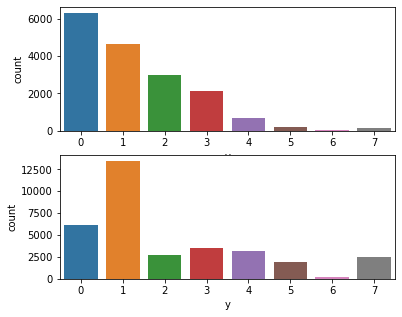

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [16]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [17]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.25141129606540363, 0.14729226093596828)

In [18]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"053_submission.csv","Stratified-Kfold(K=5)","0.251411","0.147292","","LightGBM-dart特徴量ミニマム"


In [19]:
%%time
for i, model in enumerate(models):
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(model, f)
        f.close()

Wall time: 990 ms


In [20]:
%%time
imp_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        elif hasattr(final_estimator, 'feature_names_'):
            feature_names = final_estimator.feature_names_
        else:
            feature_names = final_estimator.get_booster().feature_names
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 19.6 ms


In [21]:
imp_df

,feature,importance,fold
0,B,142054.225480,1
1,O,211911.813151,1
2,inningNo,231522.692030,1
3,totalPitchingCount,124168.643056,1
4,numRunners,45748.632655,1
...,...,...,...
13,isPitcherHandLeft,28321.665613,5
14,isBatterPitcher,5806.102185,5
15,isBottom,23677.025773,5
16,batterTeam,8553.397441,5


In [22]:
%%time
coef_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'coef_'):
            coefficient = final_estimator.coef_
            coef_df_ = pd.DataFrame(coefficient, columns=features)
            coef_df_['fold'] = i + 1
            coef_df_['y'] = final_estimator.classes_
            coef_df = pd.concat([coef_df, coef_df_])
    except AttributeError:
        pass

if coef_df.shape[0] > 0:
    coef_df.to_csv(os.path.join(OUTPUT_DIR, 'coefficients.csv'), index=False)

Wall time: 1 ms


In [23]:
coef_df

""
